# 🔤 From Text to Attention

By the end of this notebook, you'll understand:
1. How text becomes tokens (and why it matters)
2. How tokens become meaningful vectors (embeddings)
3. How position information gets added
4. How attention actually works — coded from scratch

Let's start!

---
# Part 1: Tokenization
*What does the model actually see?*

---

In [1]:
# First, install tiktoken (OpenAI's tokenizer)
!pip install tiktoken -q

In [2]:
import tiktoken
import numpy as np

# Load GPT-4's tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")

print(f"Vocabulary size: {tokenizer.n_vocab:,} tokens")

Vocabulary size: 100,277 tokens


## 1.1 Basic Tokenization

Let's see how text gets converted to numbers.

In [3]:
# Simple example
text = "Hello world"
tokens = tokenizer.encode(text)

print(f"Text: '{text}'")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

# Let's see what each token represents
print("\nToken breakdown:")
for token in tokens:
    print(f"  {token} → '{tokenizer.decode([token])}'")

Text: 'Hello world'
Tokens: [9906, 1917]
Number of tokens: 2

Token breakdown:
  9906 → 'Hello'
  1917 → ' world'


Notice: "Hello" is one token, but " world" (with the space!) is another.
The space attaches to the following word.

In [4]:
# Let's try more interesting examples
examples = [
    "Hello world",
    "don't",
    "artificial intelligence",
    "I love AI",
    "supercalifragilisticexpialidocious",
    "🚀",
    "café",
    "    spaces    ",  # multiple spaces
]

print("How different texts get tokenized:\n")
for text in examples:
    tokens = tokenizer.encode(text)
    print(f"'{text}'")
    print(f"  → {len(tokens)} tokens: {tokens}")

    # Show the pieces
    pieces = [tokenizer.decode([t]) for t in tokens]
    print(f"  → pieces: {pieces}")
    print()

How different texts get tokenized:

'Hello world'
  → 2 tokens: [9906, 1917]
  → pieces: ['Hello', ' world']

'don't'
  → 2 tokens: [15357, 956]
  → pieces: ['don', "'t"]

'artificial intelligence'
  → 3 tokens: [472, 16895, 11478]
  → pieces: ['art', 'ificial', ' intelligence']

'I love AI'
  → 3 tokens: [40, 3021, 15592]
  → pieces: ['I', ' love', ' AI']

'supercalifragilisticexpialidocious'
  → 11 tokens: [13066, 3035, 278, 333, 4193, 321, 4633, 4683, 532, 307, 78287]
  → pieces: ['sup', 'erc', 'al', 'if', 'rag', 'il', 'istic', 'exp', 'ial', 'id', 'ocious']

'🚀'
  → 3 tokens: [9468, 248, 222]
  → pieces: ['�', '�', '�']

'café'
  → 2 tokens: [936, 59958]
  → pieces: ['ca', 'fé']

'    spaces    '
  → 3 tokens: [262, 12908, 257]
  → pieces: ['   ', ' spaces', '    ']



## 🧪 Try It Yourself

Tokenize your own text! Try:
- Your name
- A sentence in another language
- Some code
- Emojis

In [5]:
# YOUR TURN: Change this text and see how it tokenizes
my_text = "my name is rishabh"

tokens = tokenizer.encode(my_text)
print(f"Text: '{my_text}'")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")
print(f"Pieces: {[tokenizer.decode([t]) for t in tokens]}")

Text: 'my name is rishabh'
Tokens: [2465, 836, 374, 436, 819, 67466]
Number of tokens: 6
Pieces: ['my', ' name', ' is', ' r', 'ish', 'abh']


## 1.2 Why Tokenization Matters

Token count affects:
- API costs (you pay per token)
- Context limits (GPT-4 has 128K token limit)
- Model behavior (some tasks break across token boundaries)

In [6]:
# Compare token efficiency across different content types

test_cases = {
    "English prose": "The quick brown fox jumps over the lazy dog.",
    "Python code": "def hello():\n    print('Hello, world!')",
    "JSON": '{"name": "Alice", "age": 30, "city": "NYC"}',
    "Numbers": "1234567890 9876543210 1111111111",
    "URL": "https://www.example.com/path/to/page?query=value",
}

print("Token efficiency comparison:\n")
for name, text in test_cases.items():
    tokens = tokenizer.encode(text)
    chars = len(text)
    ratio = chars / len(tokens)
    print(f"{name}:")
    print(f"  {chars} chars → {len(tokens)} tokens ({ratio:.1f} chars/token)")
    print()

Token efficiency comparison:

English prose:
  44 chars → 10 tokens (4.4 chars/token)

Python code:
  39 chars → 11 tokens (3.5 chars/token)

JSON:
  43 chars → 19 tokens (2.3 chars/token)

Numbers:
  32 chars → 14 tokens (2.3 chars/token)

URL:
  48 chars → 11 tokens (4.4 chars/token)



**Key insight**: Different content has different token efficiency.
- English prose: ~4 characters per token
- Code/JSON: often less efficient (more tokens per character)
- This affects your API costs!

## 1.3 The Token Boundary Problem

Some tasks are hard because they require reasoning WITHIN tokens.

In [7]:
# Why LLMs struggle with letter counting

word = "strawberry"
tokens = tokenizer.encode(word)

print(f"Word: '{word}'")
print(f"Tokens: {tokens}")
print(f"Pieces: {[tokenizer.decode([t]) for t in tokens]}")
print()
print("The model sees these pieces, not individual letters!")
print("Counting 'r's requires looking INSIDE tokens — that's hard.")

Word: 'strawberry'
Tokens: [496, 675, 15717]
Pieces: ['str', 'aw', 'berry']

The model sees these pieces, not individual letters!
Counting 'r's requires looking INSIDE tokens — that's hard.


In [8]:
# Another example: reversing words

word = "hello"
tokens = tokenizer.encode(word)
print(f"'{word}' → tokens: {[tokenizer.decode([t]) for t in tokens]}")
print()
print("If 'hello' is ONE token, the model can't easily reverse it.")
print("It would need to decompose something it sees as atomic.")

'hello' → tokens: ['hello']

If 'hello' is ONE token, the model can't easily reverse it.
It would need to decompose something it sees as atomic.


---
# ✅ Checkpoint: Tokenization Complete

You now understand:
- Text → Token IDs (integers)
- Subword tokenization (BPE)
- Why token counts matter
- Why some tasks are hard (token boundaries)

**→ Back to slides for Embeddings**

---

---
# Part 2: Embeddings
*Tokens as points in space*

---

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# We'll use a small pre-computed set of embeddings for demonstration
# In practice, you'd load these from a model

## 2.1 What's an Embedding?

An embedding converts a token ID into a vector of numbers.
Let's simulate this with random embeddings first, then use real ones.

In [10]:
# Simulating an embedding matrix
vocab_size = 50000
embedding_dim = 768  # GPT-2 size

# Random embedding matrix (in reality, this is LEARNED)
embedding_matrix = np.random.randn(vocab_size, embedding_dim) * 0.02

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"  → {vocab_size:,} tokens")
print(f"  → {embedding_dim} dimensions per token")
print(f"  → {vocab_size * embedding_dim:,} total parameters just for embeddings!")

Embedding matrix shape: (50000, 768)
  → 50,000 tokens
  → 768 dimensions per token
  → 38,400,000 total parameters just for embeddings!


In [11]:
# How embedding lookup works

text = "Hello world"
tokens = tokenizer.encode(text)

print(f"Text: '{text}'")
print(f"Token IDs: {tokens}")
print()

# Look up each token's embedding
for token_id in tokens:
    embedding = embedding_matrix[token_id]
    print(f"Token {token_id} ('{tokenizer.decode([token_id])}')")
    print(f"  → Embedding shape: {embedding.shape}")
    print(f"  → First 10 values: {embedding[:10].round(3)}")
    print()

Text: 'Hello world'
Token IDs: [9906, 1917]

Token 9906 ('Hello')
  → Embedding shape: (768,)
  → First 10 values: [ 0.014  0.023  0.006 -0.008 -0.03  -0.022 -0.034 -0.031 -0.005 -0.004]

Token 1917 (' world')
  → Embedding shape: (768,)
  → First 10 values: [-0.026 -0.01   0.001  0.002  0.007 -0.036  0.004 -0.008 -0.016  0.006]



## 2.2 Real Embeddings: Word Similarity

Let's use pre-trained word vectors to see embeddings in action.
We'll use Gensim's Word2Vec — classic but illustrative.

In [16]:
!pip install gensim -q

In [17]:
import gensim.downloader as api

# Load pre-trained word vectors (this may take a minute)
print("Loading word vectors... (this takes ~1 minute)")
word_vectors = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe
print(f"Loaded! Vocabulary: {len(word_vectors):,} words")

Loading word vectors... (this takes ~1 minute)
Loaded! Vocabulary: 400,000 words


In [18]:
# Find similar words

word = "king"
similar = word_vectors.most_similar(word, topn=10)

print(f"Words most similar to '{word}':\n")
for similar_word, score in similar:
    print(f"  {similar_word}: {score:.3f}")

Words most similar to 'king':

  prince: 0.768
  queen: 0.751
  son: 0.702
  brother: 0.699
  monarch: 0.698
  throne: 0.692
  kingdom: 0.681
  father: 0.680
  emperor: 0.671
  ii: 0.668


## 🧪 Try It Yourself

Find words similar to anything!

In [19]:
# YOUR TURN: Change this word
my_word = "computer"

if my_word in word_vectors:
    similar = word_vectors.most_similar(my_word, topn=10)
    print(f"Words most similar to '{my_word}':\n")
    for w, score in similar:
        print(f"  {w}: {score:.3f}")
else:
    print(f"'{my_word}' not in vocabulary. Try another word.")

Words most similar to 'computer':

  computers: 0.875
  software: 0.837
  technology: 0.764
  pc: 0.737
  hardware: 0.729
  internet: 0.729
  desktop: 0.723
  electronic: 0.722
  systems: 0.720
  computing: 0.714


## 2.3 The Famous Analogy: King - Man + Woman = ?

In [20]:
# Vector arithmetic with words!

result = word_vectors.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=5
)

print("king - man + woman = ?\n")
for word, score in result:
    print(f"  {word}: {score:.3f}")

king - man + woman = ?

  queen: 0.770
  monarch: 0.684
  throne: 0.676
  daughter: 0.659
  princess: 0.652


In [21]:
# Try more analogies

analogies = [
    (["paris", "germany"], ["france"], "paris - france + germany = ?"),
    (["bigger", "cold"], ["big"], "bigger - big + cold = ?"),
]

for positive, negative, description in analogies:
    print(description)
    result = word_vectors.most_similar(positive=positive, negative=negative, topn=3)
    for word, score in result:
        print(f"  {word}: {score:.3f}")
    print()

paris - france + germany = ?
  berlin: 0.885
  frankfurt: 0.799
  vienna: 0.768

bigger - big + cold = ?
  cooler: 0.688
  warmer: 0.685
  colder: 0.675



## 2.4 Visualizing Embedding Space

Embeddings are high-dimensional. Let's project to 2D to visualize.

In [22]:
# Get embeddings for a set of related words
word_groups = {
    "royalty": ["king", "queen", "prince", "princess", "royal", "throne"],
    "family": ["man", "woman", "boy", "girl", "father", "mother"],
    "animals": ["dog", "cat", "horse", "bird", "fish", "lion"],
    "tech": ["computer", "software", "internet", "digital", "data", "code"],
}

# Collect all words and their embeddings
words = []
embeddings = []
colors = []
color_map = {"royalty": "purple", "family": "blue", "animals": "green", "tech": "red"}

for group, word_list in word_groups.items():
    for word in word_list:
        if word in word_vectors:
            words.append(word)
            embeddings.append(word_vectors[word])
            colors.append(color_map[group])

embeddings = np.array(embeddings)
print(f"Collected {len(words)} words, each with {embeddings.shape[1]} dimensions")

Collected 24 words, each with 100 dimensions


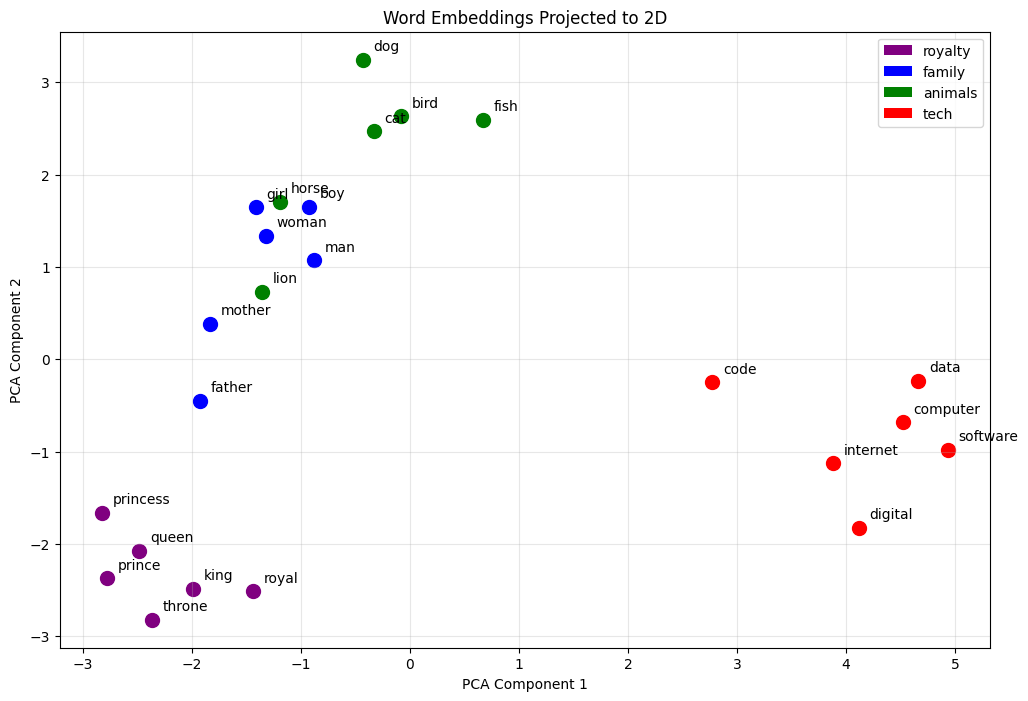

In [23]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=colors[i], s=100)
    plt.annotate(word, (embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1] + 0.1))

plt.title("Word Embeddings Projected to 2D")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=g) for g, c in color_map.items()]
plt.legend(handles=legend_elements)
plt.grid(True, alpha=0.3)
plt.show()

Notice how words cluster by meaning!
- Royalty words are near each other
- Family words form another cluster
- This structure emerges from training, not manual design

---
# ✅ Checkpoint: Embeddings Complete

You now understand:
- Token ID → Embedding vector (lookup in a matrix)
- Similar meanings = nearby vectors
- Analogies work through vector arithmetic
- Embedding space has meaningful structure

**→ Back to slides for Positional Encoding**

---

---
# Part 3: Positional Encoding
*Injecting word order*

---

## 3.1 The Problem: Attention Loses Order

Let's see why we need positional encoding.

In [24]:
# Same words, different order, different meaning

sentence1 = "dog bites man"
sentence2 = "man bites dog"

tokens1 = tokenizer.encode(sentence1)
tokens2 = tokenizer.encode(sentence2)

print(f"'{sentence1}' → {tokens1}")
print(f"'{sentence2}' → {tokens2}")
print()
print("Same tokens, just reordered!")
print("Without position info, the model can't tell these apart.")

'dog bites man' → [18964, 49433, 893]
'man bites dog' → [1543, 49433, 5679]

Same tokens, just reordered!
Without position info, the model can't tell these apart.


## 3.2 The Sinusoidal Position Encoding

The original Transformer uses sine and cosine waves to encode position.

In [25]:
def get_positional_encoding(seq_length, d_model):
    """
    Generate sinusoidal positional encodings.

    Args:
        seq_length: Maximum sequence length
        d_model: Embedding dimension

    Returns:
        Positional encoding matrix of shape (seq_length, d_model)
    """
    position = np.arange(seq_length)[:, np.newaxis]  # (seq_length, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((seq_length, d_model))
    pe[:, 0::2] = np.sin(position * div_term)  # Even indices: sine
    pe[:, 1::2] = np.cos(position * div_term)  # Odd indices: cosine

    return pe

# Generate positional encodings
seq_length = 100
d_model = 64  # Using smaller dimension for visualization

pe = get_positional_encoding(seq_length, d_model)
print(f"Positional encoding shape: {pe.shape}")
print(f"  → {seq_length} positions")
print(f"  → {d_model} dimensions")

Positional encoding shape: (100, 64)
  → 100 positions
  → 64 dimensions


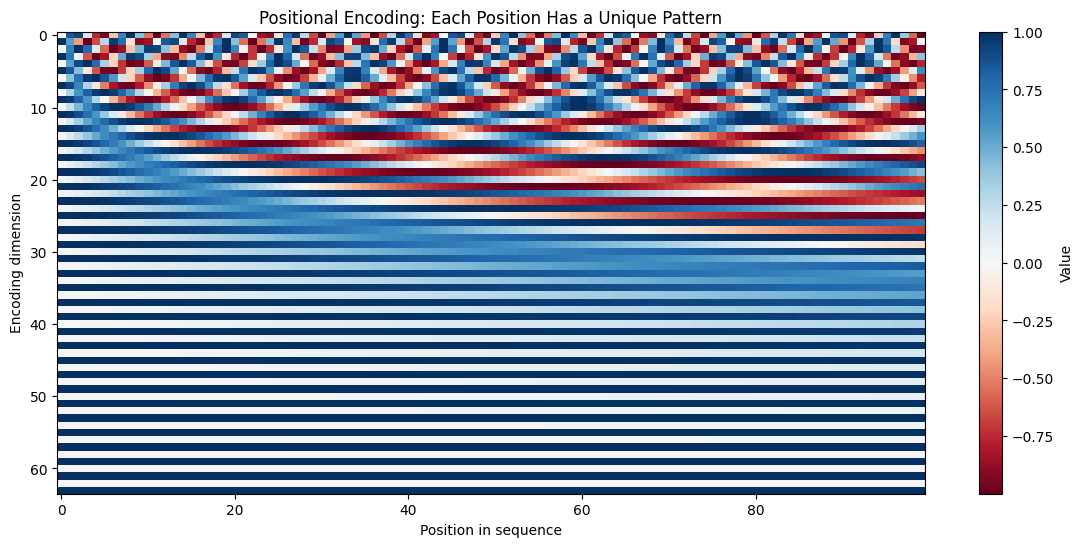

In [26]:
# Visualize the positional encodings

plt.figure(figsize=(14, 6))
plt.imshow(pe.T, aspect='auto', cmap='RdBu')
plt.colorbar(label='Value')
plt.xlabel('Position in sequence')
plt.ylabel('Encoding dimension')
plt.title('Positional Encoding: Each Position Has a Unique Pattern')
plt.show()

Each column is a position's encoding. Each row is a dimension.

Notice:
- Low dimensions (bottom) = low frequency waves (change slowly)
- High dimensions (top) = high frequency waves (change quickly)
- Each position has a UNIQUE pattern

## 3.3 How Position Gets Added

We simply ADD the positional encoding to the embedding.

In [27]:
# Simulate the full process

# Let's use a simple sentence
text = "The cat sat"
tokens = tokenizer.encode(text)
print(f"Text: '{text}'")
print(f"Tokens: {tokens}")

# Step 1: Get embeddings (using our random matrix from before)
d_model = 768
embedding_matrix = np.random.randn(50000, d_model) * 0.02
embeddings = np.array([embedding_matrix[t] for t in tokens])
print(f"\nEmbeddings shape: {embeddings.shape}")  # (3, 768)

# Step 2: Get positional encodings
pe = get_positional_encoding(len(tokens), d_model)
print(f"Positional encodings shape: {pe.shape}")  # (3, 768)

# Step 3: ADD them together
final_embeddings = embeddings + pe
print(f"Final embeddings shape: {final_embeddings.shape}")  # (3, 768)

print("\nNow each token's representation includes BOTH meaning AND position!")

Text: 'The cat sat'
Tokens: [791, 8415, 7731]

Embeddings shape: (3, 768)
Positional encodings shape: (3, 768)
Final embeddings shape: (3, 768)

Now each token's representation includes BOTH meaning AND position!


In [28]:
# Verify: same word at different positions has different representation

# "the" at position 0
the_pos0 = embedding_matrix[tokenizer.encode("the")[0]] + get_positional_encoding(1, d_model)[0]

# "the" at position 5 (simulated)
the_pos5 = embedding_matrix[tokenizer.encode("the")[0]] + get_positional_encoding(6, d_model)[5]

# How different are they?
difference = np.linalg.norm(the_pos0 - the_pos5)
print(f"Same word 'the' at position 0 vs position 5:")
print(f"  Euclidean distance: {difference:.4f}")
print(f"\nThe same word has DIFFERENT representations at different positions!")

Same word 'the' at position 0 vs position 5:
  Euclidean distance: 14.1023

The same word has DIFFERENT representations at different positions!


---
# ✅ Checkpoint: Positional Encoding Complete

You now understand:
- Why position matters (word order changes meaning)
- Sine/cosine waves create unique position patterns
- Position encoding ADDS to embeddings
- Same word at different positions → different representation

**→ Back to slides for Self-Attention**

---

---
# Part 4: Self-Attention
*The heart of the Transformer*

---

## 4.1 The Setup

We'll implement self-attention from scratch on a toy example.

In [29]:
import numpy as np

# Our sentence
sentence = ["The", "cat", "sat"]

# For simplicity, let's use small dimensions
d_model = 8  # Embedding dimension
d_k = 4       # Key/Query dimension
d_v = 4       # Value dimension

# Random embeddings for our words (pretend these are meaningful)
np.random.seed(42)
embeddings = {
    "The": np.random.randn(d_model),
    "cat": np.random.randn(d_model),
    "sat": np.random.randn(d_model),
}

# Stack into a matrix: (seq_length, d_model)
X = np.array([embeddings[word] for word in sentence])
print(f"Input shape: {X.shape}  (3 words, {d_model} dimensions each)")

Input shape: (3, 8)  (3 words, 8 dimensions each)


## 4.2 Computing Q, K, V

Each word gets transformed into Query, Key, and Value vectors.

In [30]:
# Weight matrices (these would be LEARNED in a real model)
np.random.seed(123)
W_Q = np.random.randn(d_model, d_k) * 0.1  # (8, 4)
W_K = np.random.randn(d_model, d_k) * 0.1  # (8, 4)
W_V = np.random.randn(d_model, d_v) * 0.1  # (8, 4)

print(f"W_Q shape: {W_Q.shape}  (projects {d_model}D embedding to {d_k}D query)")
print(f"W_K shape: {W_K.shape}  (projects {d_model}D embedding to {d_k}D key)")
print(f"W_V shape: {W_V.shape}  (projects {d_model}D embedding to {d_v}D value)")

W_Q shape: (8, 4)  (projects 8D embedding to 4D query)
W_K shape: (8, 4)  (projects 8D embedding to 4D key)
W_V shape: (8, 4)  (projects 8D embedding to 4D value)


In [31]:
# Compute Q, K, V for all words at once

Q = X @ W_Q  # (3, 8) @ (8, 4) = (3, 4)
K = X @ W_K  # (3, 8) @ (8, 4) = (3, 4)
V = X @ W_V  # (3, 8) @ (8, 4) = (3, 4)

print(f"Q shape: {Q.shape}  (3 words, each with a {d_k}D query)")
print(f"K shape: {K.shape}  (3 words, each with a {d_k}D key)")
print(f"V shape: {V.shape}  (3 words, each with a {d_v}D value)")

Q shape: (3, 4)  (3 words, each with a 4D query)
K shape: (3, 4)  (3 words, each with a 4D key)
V shape: (3, 4)  (3 words, each with a 4D value)


In [32]:
# Let's see what these look like for each word

for i, word in enumerate(sentence):
    print(f"\n'{word}':")
    print(f"  Query (what am I looking for?): {Q[i].round(3)}")
    print(f"  Key (what do I contain?):       {K[i].round(3)}")
    print(f"  Value (what do I contribute?):  {V[i].round(3)}")


'The':
  Query (what am I looking for?): [-0.014 -0.38   0.058 -0.618]
  Key (what do I contain?):       [-0.071  0.146  0.687  0.154]
  Value (what do I contribute?):  [ 0.422  0.105 -0.135 -0.289]

'cat':
  Query (what am I looking for?): [ 0.028  0.039 -0.032  0.26 ]
  Key (what do I contain?):       [-0.315  0.01  -0.497 -0.362]
  Value (what do I contribute?):  [-0.446  0.126  0.161  0.405]

'sat':
  Query (what am I looking for?): [0.084 0.525 0.23  0.628]
  Key (what do I contain?):       [ 0.425  0.496 -0.649 -0.064]
  Value (what do I contribute?):  [-0.05  -0.201  0.637  0.12 ]


## 4.3 Computing Attention Scores

Now each Query asks: "How well do I match each Key?"

In [33]:
# Attention scores = Q @ K^T
# Each query (row) gets a score for each key (column)

scores = Q @ K.T  # (3, 4) @ (4, 3) = (3, 3)

print("Raw attention scores:")
print(f"Shape: {scores.shape}  (3 queries × 3 keys)\n")

# Display as a table
print("         ", end="")
for word in sentence:
    print(f"{word:>8}", end="")
print()

for i, word in enumerate(sentence):
    print(f"{word:>8} ", end="")
    for j in range(len(sentence)):
        print(f"{scores[i,j]:>8.3f}", end="")
    print()

Raw attention scores:
Shape: (3, 3)  (3 queries × 3 keys)

              The     cat     sat
     The   -0.110   0.196  -0.192
     cat    0.022  -0.087   0.035
     sat    0.326  -0.363   0.106


Each row shows how much that word's Query matches each word's Key.

But these are raw scores. We need to:
1. Scale them (divide by √d_k)
2. Convert to probabilities (softmax)

In [34]:
# Scale by sqrt(d_k) - prevents extreme values
scaled_scores = scores / np.sqrt(d_k)

print(f"Scaled by √{d_k} = {np.sqrt(d_k):.2f}")
print("\nScaled attention scores:")
print(scaled_scores.round(3))

Scaled by √4 = 2.00

Scaled attention scores:
[[-0.055  0.098 -0.096]
 [ 0.011 -0.043  0.017]
 [ 0.163 -0.182  0.053]]


In [35]:
# Softmax: convert to probabilities (each row sums to 1)

def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

attention_weights = softmax(scaled_scores)

print("Attention weights (after softmax):")
print(f"Shape: {attention_weights.shape}\n")

# Display as a table
print("           ", end="")
for word in sentence:
    print(f"{word:>8}", end="")
print("    | Sum")
print("-" * 50)

for i, word in enumerate(sentence):
    print(f"{word:>8}   ", end="")
    for j in range(len(sentence)):
        print(f"{attention_weights[i,j]:>8.3f}", end="")
    print(f"  | {attention_weights[i].sum():.3f}")

Attention weights (after softmax):
Shape: (3, 3)

                The     cat     sat    | Sum
--------------------------------------------------
     The      0.320   0.373   0.307  | 1.000
     cat      0.339   0.321   0.341  | 1.000
     sat      0.384   0.272   0.344  | 1.000


**This is the attention pattern!**

Each row shows how much each word "attends to" other words.
- Row 1: How "The" distributes its attention
- Row 2: How "cat" distributes its attention  
- Row 3: How "sat" distributes its attention

Each row sums to 1 (it's a probability distribution).

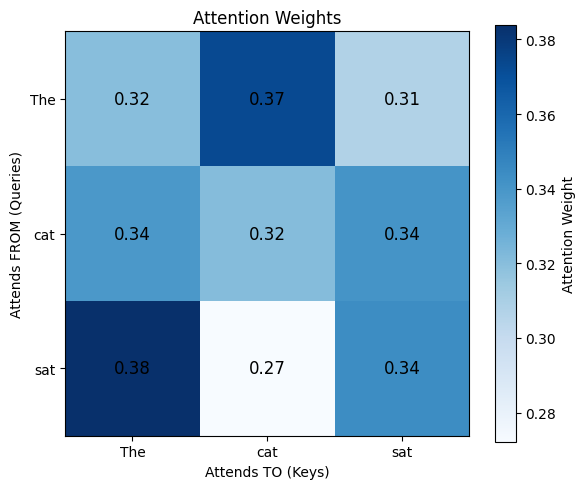

In [36]:
# Visualize the attention pattern

plt.figure(figsize=(6, 5))
plt.imshow(attention_weights, cmap='Blues')
plt.colorbar(label='Attention Weight')

plt.xticks(range(len(sentence)), sentence)
plt.yticks(range(len(sentence)), sentence)
plt.xlabel('Attends TO (Keys)')
plt.ylabel('Attends FROM (Queries)')
plt.title('Attention Weights')

# Add values in cells
for i in range(len(sentence)):
    for j in range(len(sentence)):
        plt.text(j, i, f'{attention_weights[i,j]:.2f}',
                ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

## 4.4 Computing the Output

Finally, each word gets a weighted combination of all Values.

In [37]:
# Output = attention_weights @ V
# Each word's output is a weighted sum of all Value vectors

output = attention_weights @ V  # (3, 3) @ (3, 4) = (3, 4)

print(f"Output shape: {output.shape}  (3 words, each with {d_v}D output)\n")

for i, word in enumerate(sentence):
    print(f"'{word}' output: {output[i].round(3)}")

Output shape: (3, 4)  (3 words, each with 4D output)

'The' output: [-0.047  0.019  0.212  0.095]
'cat' output: [-0.017  0.007  0.223  0.073]
'sat' output: [0.023 0.005 0.211 0.041]


**What just happened?**

Each word's output is now CONTEXTUALIZED. It contains information
from other words, weighted by the attention scores.

If "cat" attended strongly to "sat", then "cat"'s output contains
information from "sat"'s Value vector.

In [38]:
# Let's trace through one word manually

print("Manual calculation for 'cat' (word index 1):\n")

word_idx = 1
print(f"'cat' attention weights: {attention_weights[word_idx].round(3)}")
print(f"  → {attention_weights[word_idx, 0]:.3f} × V_The")
print(f"  → {attention_weights[word_idx, 1]:.3f} × V_cat")
print(f"  → {attention_weights[word_idx, 2]:.3f} × V_sat")
print()

# Manual weighted sum
manual_output = (
    attention_weights[word_idx, 0] * V[0] +
    attention_weights[word_idx, 1] * V[1] +
    attention_weights[word_idx, 2] * V[2]
)

print(f"Manual calculation: {manual_output.round(3)}")
print(f"Matrix calculation: {output[word_idx].round(3)}")
print(f"Match: {np.allclose(manual_output, output[word_idx])}")

Manual calculation for 'cat' (word index 1):

'cat' attention weights: [0.339 0.321 0.341]
  → 0.339 × V_The
  → 0.321 × V_cat
  → 0.341 × V_sat

Manual calculation: [-0.017  0.007  0.223  0.073]
Matrix calculation: [-0.017  0.007  0.223  0.073]
Match: True


## 4.5 Putting It All Together

Let's wrap the entire attention mechanism in one function.

In [39]:
def self_attention(X, W_Q, W_K, W_V):
    """
    Compute self-attention.

    Args:
        X: Input embeddings, shape (seq_length, d_model)
        W_Q: Query weight matrix, shape (d_model, d_k)
        W_K: Key weight matrix, shape (d_model, d_k)
        W_V: Value weight matrix, shape (d_model, d_v)

    Returns:
        output: Contextualized embeddings, shape (seq_length, d_v)
        attention_weights: Attention pattern, shape (seq_length, seq_length)
    """
    # Step 1: Compute Q, K, V
    Q = X @ W_Q
    K = X @ W_K
    V = X @ W_V

    # Step 2: Compute attention scores
    d_k = Q.shape[-1]
    scores = Q @ K.T / np.sqrt(d_k)

    # Step 3: Softmax to get weights
    attention_weights = softmax(scores)

    # Step 4: Weighted sum of values
    output = attention_weights @ V

    return output, attention_weights

# Test it
output, weights = self_attention(X, W_Q, W_K, W_V)
print(f"Input shape:  {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention pattern shape: {weights.shape}")

Input shape:  (3, 8)
Output shape: (3, 4)
Attention pattern shape: (3, 3)


# 🎯 Summary: The Full Pipeline

```
Text: "The cat sat"
         ↓
    [Tokenization]
         ↓
Token IDs: [464, 3797, 3332]
         ↓
    [Embedding Lookup]
         ↓
Embeddings: [[0.1, -0.2, ...], [0.3, 0.1, ...], [-0.1, 0.4, ...]]
         ↓
    [Add Positional Encoding]
         ↓
Position-aware embeddings
         ↓
    [Self-Attention]
         ↓
Contextualized embeddings (each word "knows about" other words)
```
